In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

In [3]:
file_list = os.listdir("/works/Data/Dacon/health_data_clf/")
file_list = [file for file in file_list if file.endswith(".csv")]
print(file_list)

['train_labels.csv', 'test_features.csv', 'train_features.csv', 'sample_submission.csv']


In [4]:
file_path = "/works/Data/Dacon/health_data_clf/"
train_label = pd.read_csv(file_path + file_list[0])
test_features = pd.read_csv(file_path + file_list[1])
train_features = pd.read_csv(file_path + file_list[2])
sample_submissuib = pd.read_csv(file_path + file_list[3])

print(train_label.shape)
print(test_features.shape)
print(train_features.shape)

(3125, 3)
(469200, 8)
(1875000, 8)


# Preprocessing module

In [5]:
def prerpocessing_using_static(features_set, label_set):
    input_set = []
    target_set = []
    
    for id_idx in range(features_set.id.min(), features_set.id.max()+1):
        sample_features = features_set[["acc_x","acc_y","acc_z","gy_x","gy_y","gy_z"]][features_set.id==id_idx].values
        
        #Delete noise & principa component
        sample_features_cum = sample_features[0,:].reshape(1,6)
        for idx in range(1, sample_features.shape[0]):
            sample_features_cum = np.concatenate(
                                                 (sample_features_cum, (sample_features[:idx,:].sum(axis=0).reshape(1,6))
                                                 ), axis=0)
        
        principal_eigen_vector = (sample_features_cum[-1,:] - sample_features_cum[0,:]) / len(sample_features_cum)
        
        sample_features_cum_kl = sample_features_cum[0,:].reshape(1,6)
        for idx in range(1, sample_features_cum.shape[0]):
            sample_features_cum_kl = np.concatenate(
                                                    (sample_features_cum_kl,
                                                    (sample_features_cum[idx,:]-(principal_eigen_vector*idx)).reshape(1,6))
                                                   , axis=0)
        sample_features_cum_kl_mean = sample_features_cum_kl.mean(axis=0)
        sample_features_cum_kl_std = sample_features_cum_kl.std(axis=0)
        
        sample_features_cum_kl_norm = (sample_features_cum_kl-sample_features_cum_kl_mean) / sample_features_cum_kl_std
        
        # Fourier transform
        transformed = np.fft.fft(sample_features_cum_kl_norm, axis=0)
        transformed = np.abs(transformed)
        freq = np.fft.fftfreq(len(transformed))
        transformed = transformed[freq>=0]
        
        #Append
        input_set.append(transformed)
        target_set.append(label_set[label_set.id == id_idx].label.values[0])
    
    input_set = np.array(input_set)
    target_set = np.array(target_set)
    print("Input set : {} / Target set : {}".format(input_set.shape, target_set.shape))
    return input_set, target_set

In [6]:
input_set, target_set = prerpocessing_using_static(features_set=train_features, label_set=train_label)

KeyboardInterrupt: 

In [7]:
input_set = input_set.reshape(input_set.shape[0],input_set.shape[1],input_set.shape[2],1)

# Data Split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(input_set, target_set, test_size=0.3, stratify=target_set)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

In [9]:
def return_tensorflow_model(input_shape_tuple):
    input_tens = tf.keras.Input(shape=input_shape_tuple)
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,1))(input_tens)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,1))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,1))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3,2))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3,2))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,1))(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=(3,1))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=(3,1))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,1))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(61, activation="softmax")(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    print(model.summary())
    return model

In [12]:
model = return_tensorflow_model(input_shape_tuple=(300,6,1))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 6, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 296, 6, 128)       768       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 296, 6, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 292, 6, 64)        41024     
_________________________________________________________________
re_lu_7 (ReLU)               (None, 292, 6, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 146, 6, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 144, 5, 32)        1232

In [14]:
model.fit(x_train, y_train, epochs=3, batch_size=512, validation_data=(x_val, y_val))

Train on 2187 samples, validate on 938 samples
Epoch 1/3
2187/2187 [==============================] - 0s 209us/sample - loss: 0.7432 - accuracy: 0.8102 - val_loss: 1.2721 - val_accuracy: 0.7079
Epoch 2/3
2187/2187 [==============================] - 0s 192us/sample - loss: 0.7070 - accuracy: 0.8166 - val_loss: 1.2856 - val_accuracy: 0.7207
Epoch 3/3
2187/2187 [==============================] - 0s 191us/sample - loss: 0.6428 - accuracy: 0.8354 - val_loss: 1.3260 - val_accuracy: 0.7154


# Result

In [15]:
train_predict = model.predict(x_train)
val_predict = model.predict(x_val)

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

def draw_confusion_matrix_and_print_accuracy(predicted_label, real_label):
    print(accuracy_score(real_label, predicted_label))
    print(confusion_matrix(real_label, predicted_label))

In [17]:
def return_armax(arrs):
    return np.argmax(arrs, axis=1)

In [18]:
train_predict = return_armax(arrs=train_predict)
val_predict = return_armax(arrs=val_predict)

In [19]:
draw_confusion_matrix_and_print_accuracy(predicted_label=train_predict, real_label=y_train)

0.8395061728395061
[[ 3  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  0  0 ... 13  0  0]
 [ 0  0  0 ...  0 15  0]
 [ 0  0  0 ...  0  0 11]]


In [20]:
draw_confusion_matrix_and_print_accuracy(predicted_label=val_predict, real_label=y_val)

0.7153518123667377
[[0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 8]]


In [21]:
import seaborn as sns
#From https://www.kaggle.com/agungor2/various-confusion-matrix-plots
def plot_cm(y_true, y_pred, figsize=(20,20)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

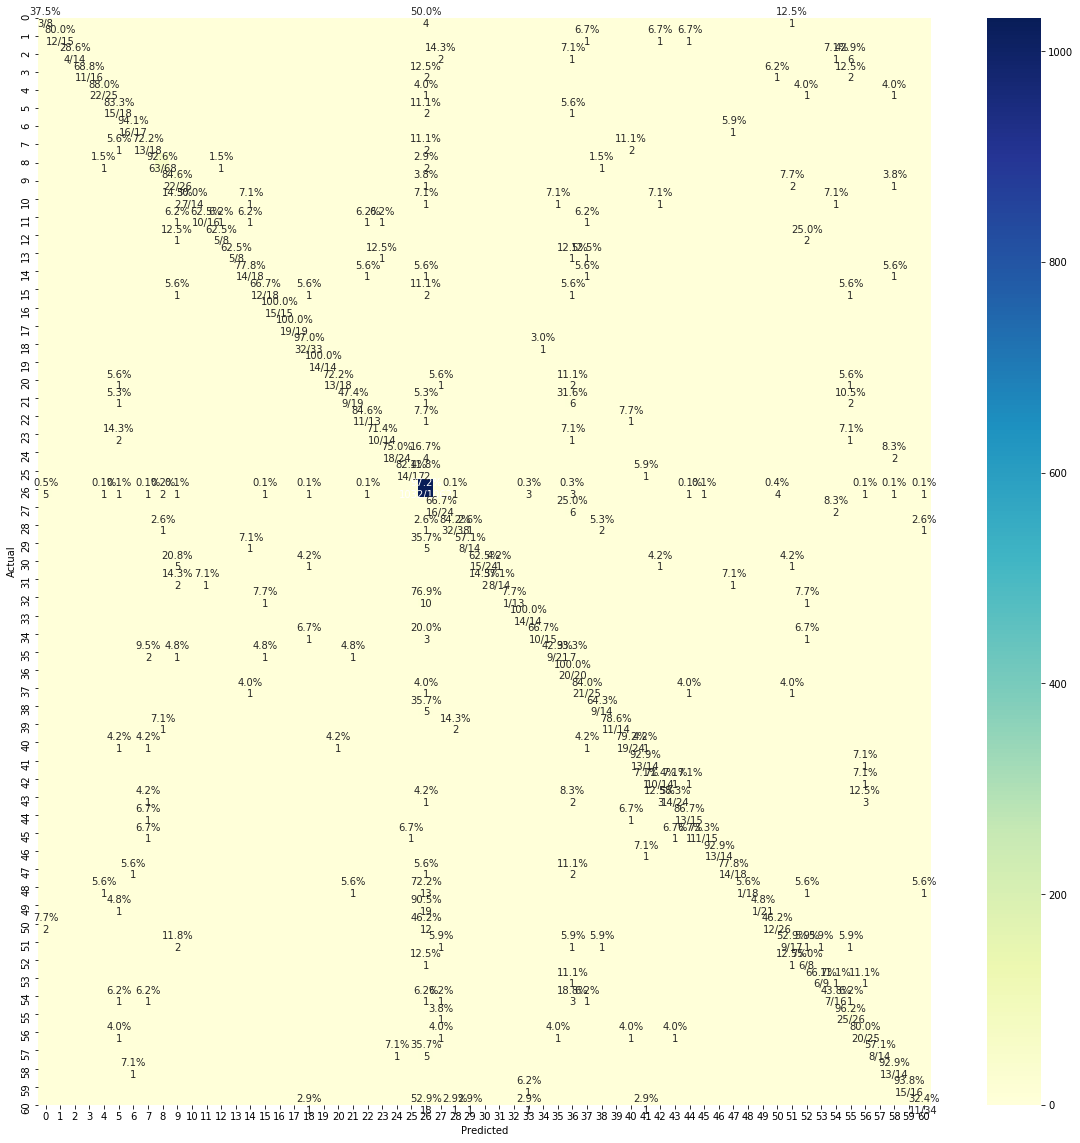

In [22]:
plot_cm(y_true=y_train, y_pred=train_predict)

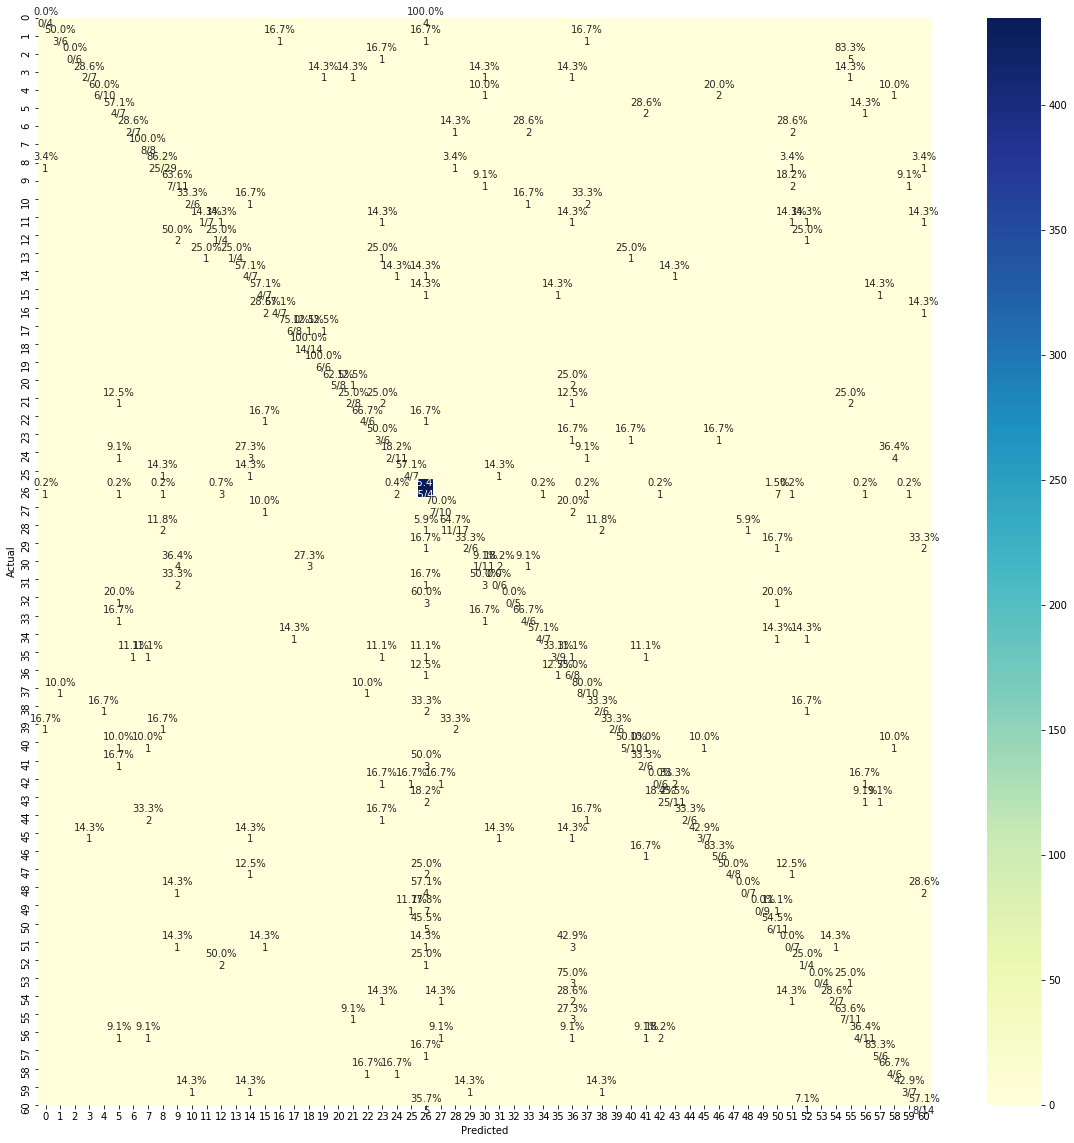

In [23]:
plot_cm(y_true=y_val, y_pred=val_predict)